## Exercise 8- Anomaly Detection & Recommender Systems

In [22]:
# import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.optimize 

### Anomaly Detection

In [23]:
# dataset 1
input_file = 'database/ex8data1.mat'

# scipy.io for loading .mat files
mat_data = scipy.io.loadmat(input_file)
X = mat_data['X']
X_val = mat_data['Xval']
y_val = mat_data['yval']

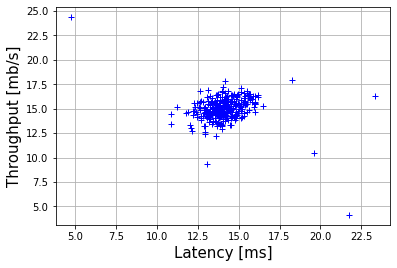

In [24]:
def plotData(X, new_figure=False):
    if new_figure:
        plt.figure(figsize=(8,5))
    plt.plot(X[:,0],X[:,1],'b+')
    plt.xlabel('Latency [ms]',fontsize=15)
    plt.ylabel('Throughput [mb/s]',fontsize=15)
    plt.grid(True)

plotData(X)

#### Gaussian Distribution

In [25]:
def gaussian_distribution(X, mu, sigma_2):
    """
    Input: X, mu, sigma^2
    Output: Gaussian values for a feature
    """
    m = X.shape[0]
    n = X.shape[1]
    if np.ndim(sigma_2) == 1:
        sigma_2 = np.diag(sigma_2)

    norm = 1./(np.power((2*np.pi), n/2)*np.sqrt(np.linalg.det(sigma_2)))
    inv = np.linalg.inv(sigma_2)
    exp = np.zeros((m,1))
    for row_i in range(m):
        row_x = X[row_i]
        exp[row_i] = np.exp(-0.5*((row_x-mu).T).dot(inv).dot(row_x-mu))
        
    return norm*exp

# function for estimating parameters for a Gaussian distribution, returns mu and sigma^2
# can be done per feature or using the Multivariate Gaussian approach
def get_GaussianParameters(X,use_Multivariate = True):
    m = X.shape[0]
    mu = np.mean(X,axis=0)
    if not use_Multivariate:
        sigma_2 = np.sum(np.square(X-mu),axis=0)/float(m)
        return mu, sigma_2
    else:
        sigma_2 = ((X-mu).T.dot(X-mu))/float(m)
        return mu, sigma_2
    
mu, sigma_2 = get_GaussianParameters(X, use_Multivariate = True)
display(mu, sigma_2)

array([14.11222578, 14.99771051])

array([[ 1.83263141, -0.22712233],
       [-0.22712233,  1.70974533]])

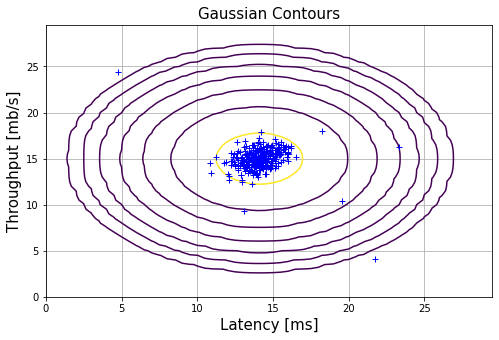

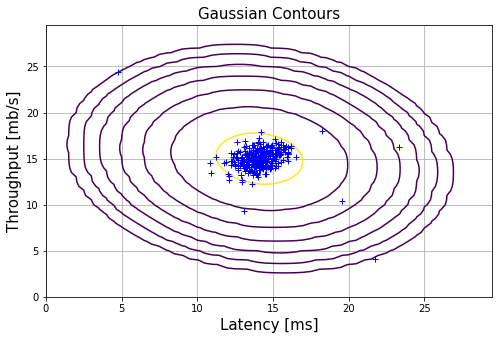

In [26]:
# visualizing the Gaussian contours
def plotContours(mu, sigma_2, new_figure=False, use_Multivariate =True):
    delta = .5
    x = np.arange(0,30,delta)
    y = np.arange(0,30,delta)
    mesh_x, mesh_y = np.meshgrid(x,y)
    coordinate_list = [entry.ravel() for entry in (mesh_x, mesh_y)]
    points = np.vstack(coordinate_list).T
    z = gaussian_distribution(points, mu, sigma_2)
    z = z.reshape((x.shape[0],x.shape[0]))
    
    if new_figure:
        plt.figure(figsize=(8,5))
    
    contour_levels = [10**exp for exp in range(-20,0,3)]
    _cont = plt.contour(mesh_x, mesh_y, z, levels=contour_levels)
    plt.title('Gaussian Contours',fontsize=15)
    

# plotting contours without using Multivariate Gaussian
plotData(X,new_figure=True)
plotContours(*get_GaussianParameters(X, False), new_figure=False, use_Multivariate = False)

# now plotting contours with Multivariate Gaussian
plotData(X,new_figure=True)
plotContours(*get_GaussianParameters(X, True), new_figure=False, use_Multivariate = True)

##### As you can infer from the above 2 diagrams, the one in which we are not using Multivariate Gaussian, the plot is inclined with the axis; whereas, the one with Multivariate Gaussian is at an angle.

#### Selecting the Threshold '$\epsilon$'

In [27]:
def calculate_F1(predicted_vector, true_vector):
    """
    F1 Score = (2 * (Precision * Recall)/(Precision + Recall))
    """
    P, R = 0., 0.
    if float(np.sum(predicted_vector)):
        P = np.sum([int(true_vector[x]) for x in range(predicted_vector.shape[0]) \
                    if predicted_vector[x]]) / float(np.sum(predicted_vector))
    if float(np.sum(true_vector)):
        R = np.sum([int(predicted_vector[x]) for x in range(true_vector.shape[0]) \
                    if true_vector[x]]) / float(np.sum(true_vector))
        
    return 2*P*R/(P+R) if (P+R) else 0

# function for selecting best epsilon from a set of values
def selectThreshold(y_val, prob_value):
    # making a list of possible epsilon values
    num_steps = 1000
    epsilons = np.linspace(np.min(prob_value),np.max(prob_value),num_steps)
    # display(epsilons)
    
    # compute the F1 score for each epsilon value, and storing the best one
    F1_best, epsilon_best = 0, 0
    true_vector = (y_val == 1).flatten()
    for e in epsilons:
        predicted_vector = prob_value < e
        current_F1 = calculate_F1(predicted_vector, true_vector)
        if current_F1 > F1_best:
            F1_best = current_F1
            epsilon_best = e
            
    print("Best F1 Score  = %f\nBest Epsilon = %0.4g."%(F1_best,epsilon_best))
    return F1_best, epsilon_best

# finding the best parameters
prob_value = gaussian_distribution(X_val, mu, sigma_2)
F1_best, epsilon_best = selectThreshold(y_val,prob_value)

Best F1 Score  = 0.875000
Best Epsilon = 9.075e-05.


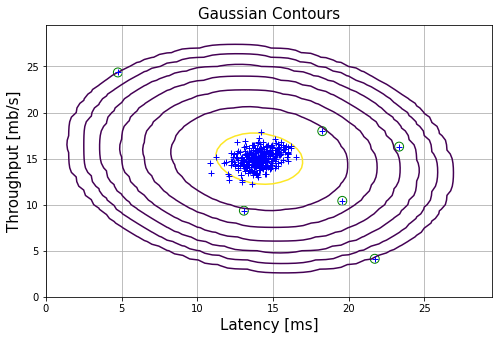

In [28]:
# plotting anomalies
def plotAnomalies(X, epsilon_best, new_figure = False, use_Multivariate = True):
    params = gaussian_distribution(X, *get_GaussianParameters(X, use_Multivariate))
    anomalies = np.array([X[x] for x in range(X.shape[0]) if params[x] < epsilon_best])
    if new_figure: 
        plt.figure(figsize=(8,5))
    plt.scatter(anomalies[:,0],anomalies[:,1], s=80, facecolors='none', edgecolors='g') # anomalies marked in green
    
plotData(X, new_figure=True)
plotContours(mu, sigma_2, new_figure=False, use_Multivariate=True)
plotAnomalies(X, epsilon_best, new_figure=False, use_Multivariate=True)

In [29]:
# dataset 2
input_file = 'database/ex8data2.mat'

# scipy.io for loading .mat files
mat_data = scipy.io.loadmat(input_file)
X_2 = mat_data['X']
X_val_2 = mat_data['Xval']
y_val_2 = mat_data['yval']

In [30]:
mu, sigma_2 = get_GaussianParameters(X_2, use_Multivariate=False)
prob_value = gaussian_distribution(X_2, mu, sigma_2)
prob_value_val = gaussian_distribution(X_val_2, mu, sigma_2)


F1_best, epsilon_best = selectThreshold(y_val_2,prob_value_val)
anomalies = [X_2[x] for x in range(X_2.shape[0]) if prob_value[x] < epsilon_best]
print ('Number of anomalies found: ',len(anomalies))

Best F1 Score  = 0.615385
Best Epsilon = 1.379e-18.
Number of anomalies found:  117


### Recommender Systems

In [31]:
# dataset 3 
input_file = 'database/ex8_movies.mat'

# scipy.io for loading .mat files
mat_data = scipy.io.loadmat(input_file)

# R = 1682*943 matrix containing R(i,j) = 1 if user 'j' assigned a rating to movie 'i'
# Y = 1682*943 matrix containing 1682 ratings by 943 users
R = mat_data['R']
Y = mat_data['Y']

nm, nu = Y.shape

Average rating for Movie #23 (Taxi Driver): 4.12


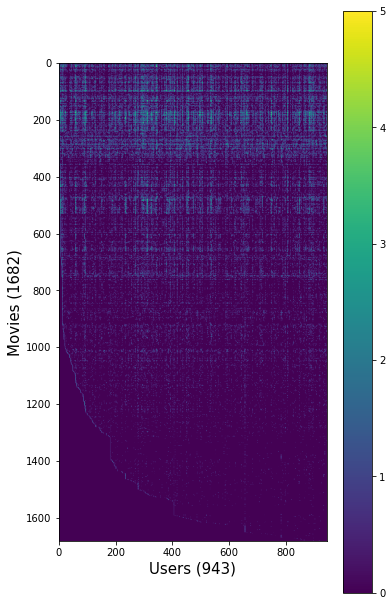

In [32]:
print ('Average rating for Movie #23 (Taxi Driver): %0.2f' % \
    np.mean([Y[22][x] for x in range(Y.shape[1]) if R[22][x]]))

# visualizing the ratings matrix
figure = plt.figure(figsize=(6,6*(1682./943.)))
temp = plt.imshow(Y)
temp = plt.colorbar()
temp = plt.ylabel('Movies (%d)'%nm,fontsize=15)
temp = plt.xlabel('Users (%d)'%nu,fontsize=15)

#### Collaborative Filtering

In [33]:
# dataset 3's movie parameters matrices
input_file = 'database/ex8_movieParams.mat'

# scipy.io for loading .mat files
mat_data = scipy.io.loadmat(input_file)
X = mat_data['X']
Theta = mat_data['Theta']
nu = int(mat_data['num_users'])
nm = int(mat_data['num_movies'])
nf = int(mat_data['num_features'])

# reducing the dataset (temporarily)
nu = 4; nm = 5; nf = 3
X = X[:nm,:nf]
Theta = Theta[:nu,:nf]
Y = Y[:nm,:nu]
R = R[:nm,:nu]

In [34]:
# flattening the parameters
def flattenParameters(X, Theta):
    """
    Input: X
    Output: numpy array (nm*nf+nu*nf, 1)
    """
    return np.concatenate((X.flatten(),Theta.flatten()))

# function to reshape X and Theta
def reshapeParameters(flattened_X_Theta, _nm, _nu, _nf):
    assert flattened_X_Theta.shape[0] == int(nm*nf+nu*nf)
    
    reshaped_X = flattened_X_Theta[:int(_nm*_nf)].reshape((_nm,_nf))
    reshaped_Theta = flattened_X_Theta[int(_nm*_nf):].reshape((_nu,_nf))
    
    return reshaped_X, reshaped_Theta

In [35]:
def cofi_CostFunc(params, Y, R, nu, nm, nf, _lambda = 0.):
    # unfolding X and Theta matrices from the flattened params
    X, Theta = reshapeParameters(params, nm, nu, nf)
    
    temp1 = X.dot(Theta.T)
    temp1 = np.multiply(temp1,R)
    cost = 0.5 * np.sum(np.square(temp1-Y))
    
    # regularizing
    cost += (_lambda/2.) * np.sum(np.square(Theta))
    cost += (_lambda/2.) * np.sum(np.square(X))
    
    return cost

# checking
print ('Cost with nu = 4, nm = 5, nf = 3, lambda = 0: %0.2f.' % \
    cofi_CostFunc(flattenParameters(X,Theta),Y,R,nu,nm,nf))

print ('Cost with nu = 4, nm = 5, nf = 3, lambda = 2: %0.2f.' % \
    cofi_CostFunc(flattenParameters(X,Theta),Y,R,nu,nm,nf,_lambda=2))

Cost with nu = 4, nm = 5, nf = 3, lambda = 0: 22.22.
Cost with nu = 4, nm = 5, nf = 3, lambda = 2: 34.38.


In [36]:
# Collaborative Filtering gradient
def cofiGrad(params, Y, R, nu, nm, nf, _lambda = 0.): 
    # unfolding X and Theta matrices from the flattened params
    X, Theta = reshapeParameters(params, nm, nu, nf)

    temp1 = X.dot(Theta.T)
    temp1 = np.multiply(temp1,R)
    temp1 -= Y
    
    X_gradient = temp1.dot(Theta)
    theta_gradient = temp1.T.dot(X)
    
    # regularizing
    X_gradient += _lambda * X
    theta_gradient += _lambda * Theta
    
    return flattenParameters(X_gradient, theta_gradient)

# checking the gradient
def checkGrad(params, Y, R, nu, nm, nf, _lambda = 0.):
    
    print ('Numerical Gradient \t cofiGrad \t\t Difference')
    
    # computing the numerical gradient using epsilon vector
    epsilon = 0.0001
    num_params = len(params)
    epsilon_vector = np.zeros(num_params)

    calculated_gradients = cofiGrad(params,Y,R,nu,nm,nf,_lambda)

    # displaying collaborative filtering gradient alongside numerical gradient
    for i in range(10):
        idx = np.random.randint(0,num_params)
        epsilon_vector[idx] = epsilon
        loss1 = cofi_CostFunc(params-epsilon_vector,Y,R,nu,nm,nf,_lambda)
        loss2 = cofi_CostFunc(params+epsilon_vector,Y,R,nu,nm,nf,_lambda)
        calculated_gradient = (loss2 - loss1) / (2*epsilon)
        epsilon_vector[idx] = 0
        print ('%0.15f \t %0.15f \t %0.15f' % (calculated_gradient, calculated_gradients[idx],calculated_gradient - calculated_gradients[idx]))      

In [37]:
# checking
print ("Checking gradient difference with lambda = 0:")
checkGrad(flattenParameters(X,Theta),Y,R,nu,nm,nf)
print ("\nChecking gradient difference with lambda = 2:")
checkGrad(flattenParameters(X,Theta),Y,R,nu,nm,nf,_lambda = 2)

Checking gradient difference with lambda = 0:
Numerical Gradient 	 cofiGrad 		 Difference
-0.740408710786511 	 -0.740408710778314 	 -0.000000000008196
-0.353340482881492 	 -0.353340482875070 	 -0.000000000006423
2.263336983912012 	 2.263336983921972 	 -0.000000000009960
0.000000000000000 	 0.000000000000000 	 0.000000000000000
-0.383582784628800 	 -0.383582784622124 	 -0.000000000006676
-3.050990064075165 	 -3.050990064071511 	 -0.000000000003654
0.000000000000000 	 0.000000000000000 	 0.000000000000000
-7.160044429745938 	 -7.160044429740946 	 -0.000000000004992
-2.528991646091328 	 -2.528991646082334 	 -0.000000000008994
3.352650312855587 	 3.352650312849549 	 0.000000000006038

Checking gradient difference with lambda = 2:
Numerical Gradient 	 cofiGrad 		 Difference
1.071295716279508 	 1.071295716262144 	 0.000000000017364
-0.543787810585172 	 -0.543787810580372 	 -0.000000000004800
0.518997116820685 	 0.518997116841195 	 -0.000000000020510
-0.016502804420782 	 -0.016502804455492 	 

In [38]:
# dataset containing movie names with IDs
movies = []
with open('database/movie_ids.txt',encoding = "ISO-8859-1") as f:
    for line in f:
        movies.append(' '.join(line.strip('\n').split(' ')[1:]))

# following values as per the assignment PDF
_ratings = np.zeros((1682,1))
_ratings[0] = 4
_ratings[97] = 2
_ratings[6] = 3
_ratings[11] = 5
_ratings[53] = 4
_ratings[63] = 5
_ratings[65] = 3
_ratings[68] = 5
_ratings[182] = 4
_ratings[225] = 5
_ratings[354] = 5

# reading the file again as I set the nf, nu, nm randomly earlier
input_file = 'database/ex8_movies.mat'

# scipy.io for loading .mat files
mat_data = scipy.io.loadmat(input_file)

# R = 1682*943 matrix containing R(i,j) = 1 if user 'j' assigned a rating to movie 'i'
# Y = 1682*943 matrix containing 1682 ratings by 943 users
R = mat_data['R']
Y = mat_data['Y']

# using 10 features
nf = 10

# adding my ratings to the Y matrix, and the relevant row to the R matrix
R_row = _ratings > 0
Y = np.hstack((Y,_ratings))
R = np.hstack((R,R_row))
nm, nu = Y.shape

In [39]:
# normalizing ratings
# important so as to avoid getting zero rating value for a user who was not rated any movies yet
def normalizeRatings(Y, R):
    # calculating mean using only the movies that were rated
    Y_mean = np.sum(Y,axis=1)/np.sum(R,axis=1)
    Y_mean = Y_mean.reshape((Y_mean.shape[0],1))
    return Y-Y_mean, Y_mean

Y_normalized, Y_mean = normalizeRatings(Y,R)

In [40]:
# generating random initial parameters, Theta & X
X = np.random.rand(nm,nf)
Theta = np.random.rand(nu,nf)
flat = flattenParameters(X, Theta)

# lambda as per the assignment PDF
_lambda = 10.
# training the actual model with fmin_cg
result = scipy.optimize.fmin_cg(cofi_CostFunc, x0=flat, fprime=cofiGrad, \
                               args=(Y,R,nu,nm,nf,_lambda), \
                                maxiter=50,disp=True,full_output=True)

         Current function value: 73188.938062
         Iterations: 50
         Function evaluations: 72
         Gradient evaluations: 72


In [41]:
# reshapeing the trained output into sensible 'X' & 'Theta' matrices
reshaped_X, reshaped_Theta = reshapeParameters(result[0], nm, nu, nf)

# making predictions
prediction_matrix = reshaped_X.dot(reshaped_Theta.T)

# getting the last user's predictions (in this case, mine) and putting them back
my_predictions = prediction_matrix[:,-1] + Y_mean.flatten()

In [42]:
# sorting my_predictions in descending order
predicted_idxs_sorted = np.argsort(my_predictions)
predicted_idxs_sorted[:] = predicted_idxs_sorted[::-1]

print("Recommended Movies:")
for i in range(10):
    print('Predicting rating %0.2f for: %s.' % \
    (my_predictions[predicted_idxs_sorted[i]],movies[predicted_idxs_sorted[i]]))
    
print("\nOriginal Ratings Provided:")
for i in range(len(_ratings)):
    if _ratings[i] > 0:
        print('Rated %d for: %s.' % (_ratings[i],movies[i]))

Recommended Movies:
Predicting rating 8.35 for: Shawshank Redemption, The (1994).
Predicting rating 8.29 for: Star Wars (1977).
Predicting rating 8.26 for: Raiders of the Lost Ark (1981).
Predicting rating 8.19 for: Schindler's List (1993).
Predicting rating 8.15 for: Titanic (1997).
Predicting rating 8.11 for: Close Shave, A (1995).
Predicting rating 8.09 for: Wrong Trousers, The (1993).
Predicting rating 8.08 for: Usual Suspects, The (1995).
Predicting rating 8.06 for: Empire Strikes Back, The (1980).
Predicting rating 8.02 for: Casablanca (1942).

Original Ratings Provided:
Rated 4 for: Toy Story (1995).
Rated 3 for: Twelve Monkeys (1995).
Rated 5 for: Usual Suspects, The (1995).
Rated 4 for: Outbreak (1995).
Rated 5 for: Shawshank Redemption, The (1994).
Rated 3 for: While You Were Sleeping (1995).
Rated 5 for: Forrest Gump (1994).
Rated 2 for: Silence of the Lambs, The (1991).
Rated 4 for: Alien (1979).
Rated 5 for: Die Hard 2 (1990).
Rated 5 for: Sphere (1998).
